# Tuberculosis Classification CNN Model with Attention



## Import Libraries

In [1]:
import os
import cv2
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from PIL import Image
import torchvision.transforms as T

## Download Dataset

In [ ]:
import kagglehub
import os

model_dir = os.path.join("model")
os.makedirs(model_dir, exist_ok=True)

path = kagglehub.dataset_download(
    "tawsifurrahman/tuberculosis-tb-chest-xray-dataset",
    path=model_dir
)

print("Path to dataset files:", path)

## Dataset Configuration

In [2]:
# Define dataset directories to make sure the datasets are downloaded from kaggle and is present
# if the dataset is not downloaded please refer to the readme file to download it
DATASET_DIR = os.path.join('.', 'tuberculosis-dataset')
NORMAL_DIR  = os.path.join(DATASET_DIR, 'Normal')
TB_DIR      = os.path.join(DATASET_DIR, 'Tuberculosis')

print("NORMAL_DIR exists?", os.path.exists(NORMAL_DIR))
print("TB_DIR exists?", os.path.exists(TB_DIR))

NORMAL_DIR exists? True
TB_DIR exists? True


## Load and Preprocess Images

In [3]:
big_stack_of_images = []
big_stack_of_labels = []
DIM_OF_IMAGE = 256

# Loading normal X-ray pictures, label = 0
for one_file_name in os.listdir(NORMAL_DIR):
    path_here = os.path.join(NORMAL_DIR, one_file_name)
    pic = cv2.imread(path_here, cv2.IMREAD_GRAYSCALE)
    if pic is not None:
        # Resizing to a consistent dimension
        pic = cv2.resize(pic, (DIM_OF_IMAGE, DIM_OF_IMAGE))
        big_stack_of_images.append(pic)
        big_stack_of_labels.append(0)

# Loading TB X-ray pictures, label = 1
for one_file_name in os.listdir(TB_DIR):
    path_here = os.path.join(TB_DIR, one_file_name)
    pic = cv2.imread(path_here, cv2.IMREAD_GRAYSCALE)
    if pic is not None:
        pic = cv2.resize(pic, (DIM_OF_IMAGE, DIM_OF_IMAGE))
        big_stack_of_images.append(pic)
        big_stack_of_labels.append(1)

big_stack_of_images = np.array(big_stack_of_images)
big_stack_of_labels = np.array(big_stack_of_labels)

print("Images shape:", big_stack_of_images.shape)
print("Labels shape:", big_stack_of_labels.shape)


Images shape: (4200, 256, 256)
Labels shape: (4200,)


## Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    big_stack_of_images, big_stack_of_labels, test_size=0.3, random_state=42
)

# Moving pixel range from [0,255] to [0,1] for easier training
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32')  / 255.0

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2940, 256, 256)
X_test shape: (1260, 256, 256)
y_train shape: (2940,)
y_test shape: (1260,)


## Balance Dataset with SMOTE

In [5]:
# Using SMOTE to address class imbalance; might lead to some overfitting, but it's needed
smote = SMOTE(random_state=42)

# Flattening images so SMOTE can handle them (256*256 = 65536 features)
count_train = X_train.shape[0]
X_train_2D = X_train.reshape(count_train, -1)

X_train_resampled_2D, y_train_resampled = smote.fit_resample(X_train_2D, y_train)

# Turning the 2D data back into 4D for CNN usage
X_train_resampled = X_train_resampled_2D.reshape(-1, DIM_OF_IMAGE, DIM_OF_IMAGE, 1)

print("After SMOTE, X_train_resampled shape:", X_train_resampled.shape)
print("After SMOTE, y_train_resampled shape:", y_train_resampled.shape)
unique_vals, counts = np.unique(y_train_resampled, return_counts=True)
print("Label distribution:", dict(zip(unique_vals, counts)))


After SMOTE, X_train_resampled shape: (4914, 256, 256, 1)
After SMOTE, y_train_resampled shape: (4914,)
Label distribution: {np.int64(0): np.int64(2457), np.int64(1): np.int64(2457)}


## Dataset Class Distribution

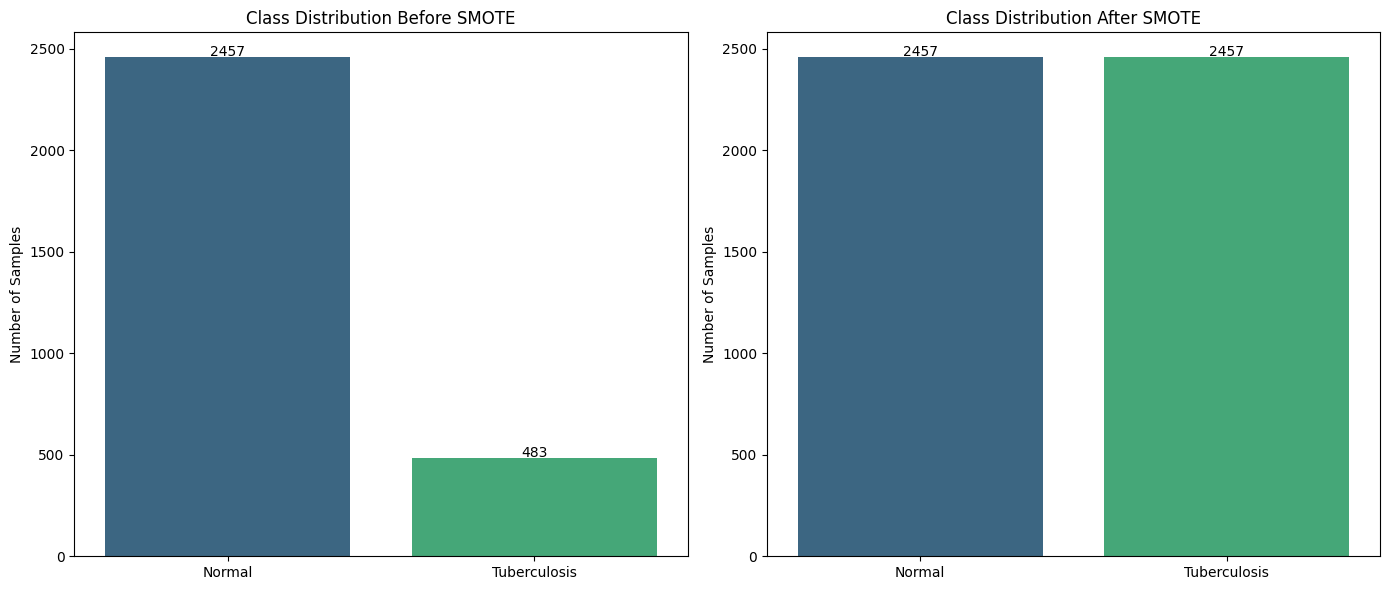

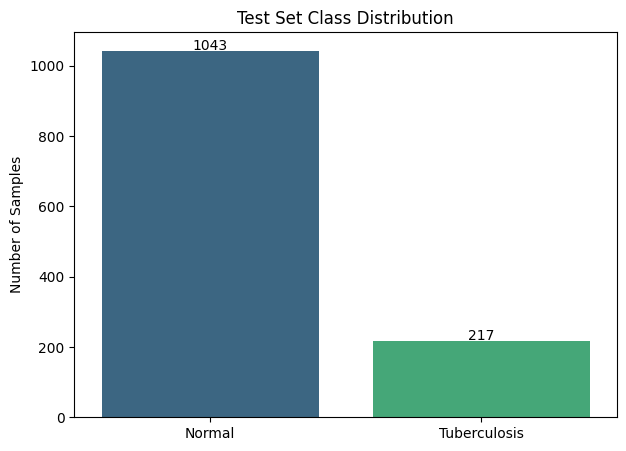

In [6]:
plt.figure(figsize=(14, 6))

# Class distribution before SMOTE
plt.subplot(1, 2, 1)
original_vals, original_counts = np.unique(y_train, return_counts=True)
sns.barplot(x=['Normal', 'Tuberculosis'],
            y=original_counts,
            hue=['Normal', 'Tuberculosis'],
            palette='viridis')
plt.title('Class Distribution Before SMOTE')
plt.ylabel('Number of Samples')
plt.legend([], [], frameon=False)  # No legend box
for i, count in enumerate(original_counts):
    plt.text(i, count + 5, str(count), ha='center')

# Class distribution after SMOTE
plt.subplot(1, 2, 2)
resampled_vals, resampled_counts = np.unique(y_train_resampled, return_counts=True)
sns.barplot(x=['Normal', 'Tuberculosis'],
            y=resampled_counts,
            hue=['Normal', 'Tuberculosis'],
            palette='viridis')
plt.title('Class Distribution After SMOTE')
plt.ylabel('Number of Samples')
plt.legend([], [], frameon=False)
for i, count in enumerate(resampled_counts):
    plt.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

# Quick look at test set distribution (no SMOTE applied)
plt.figure(figsize=(7, 5))
test_vals, test_counts = np.unique(y_test, return_counts=True)
sns.barplot(x=['Normal', 'Tuberculosis'],
            y=test_counts,
            hue=['Normal', 'Tuberculosis'],
            palette='viridis')
plt.title('Test Set Class Distribution')
plt.ylabel('Number of Samples')
plt.legend([], [], frameon=False)
for i, count in enumerate(test_counts):
    plt.text(i, count + 2, str(count), ha='center')
plt.show()


## Visualize Sample Images from Dataset

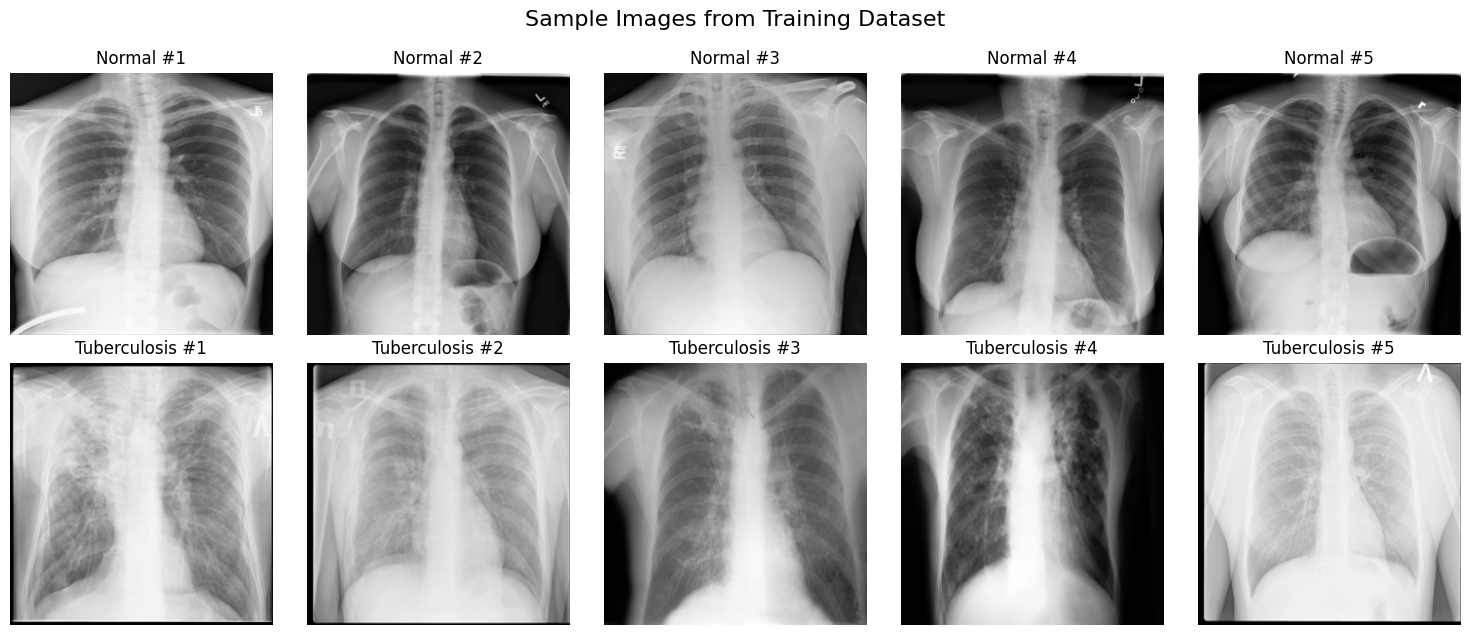

In [ ]:
# Quick sampling of images from each class
plt.figure(figsize=(15, 6))

# Indices for normal and TB images
normal_indices = np.where(y_train_resampled == 0)[0]
tb_indices = np.where(y_train_resampled == 1)[0]

# Grab 5 random samples from each class
normal_samples = np.random.choice(normal_indices, 5, replace=False)
tb_samples = np.random.choice(tb_indices, 5, replace=False)

# Display normal images
for i, idx in enumerate(normal_samples):
    plt.subplot(2, 5, i+1)
    peek_pic = np.squeeze(X_train_resampled[idx])
    plt.imshow(peek_pic, cmap='gray')
    plt.title(f"Normal #{i+1}")
    plt.axis('off')

# Display TB images
for i, idx in enumerate(tb_samples):
    plt.subplot(2, 5, i+6)
    peek_pic = np.squeeze(X_train_resampled[idx])
    plt.imshow(peek_pic, cmap='gray')
    plt.title(f"Tuberculosis #{i+1}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Images from Training Dataset", y=1.05, fontsize=16)
plt.show()


## Image Intensity Analysis

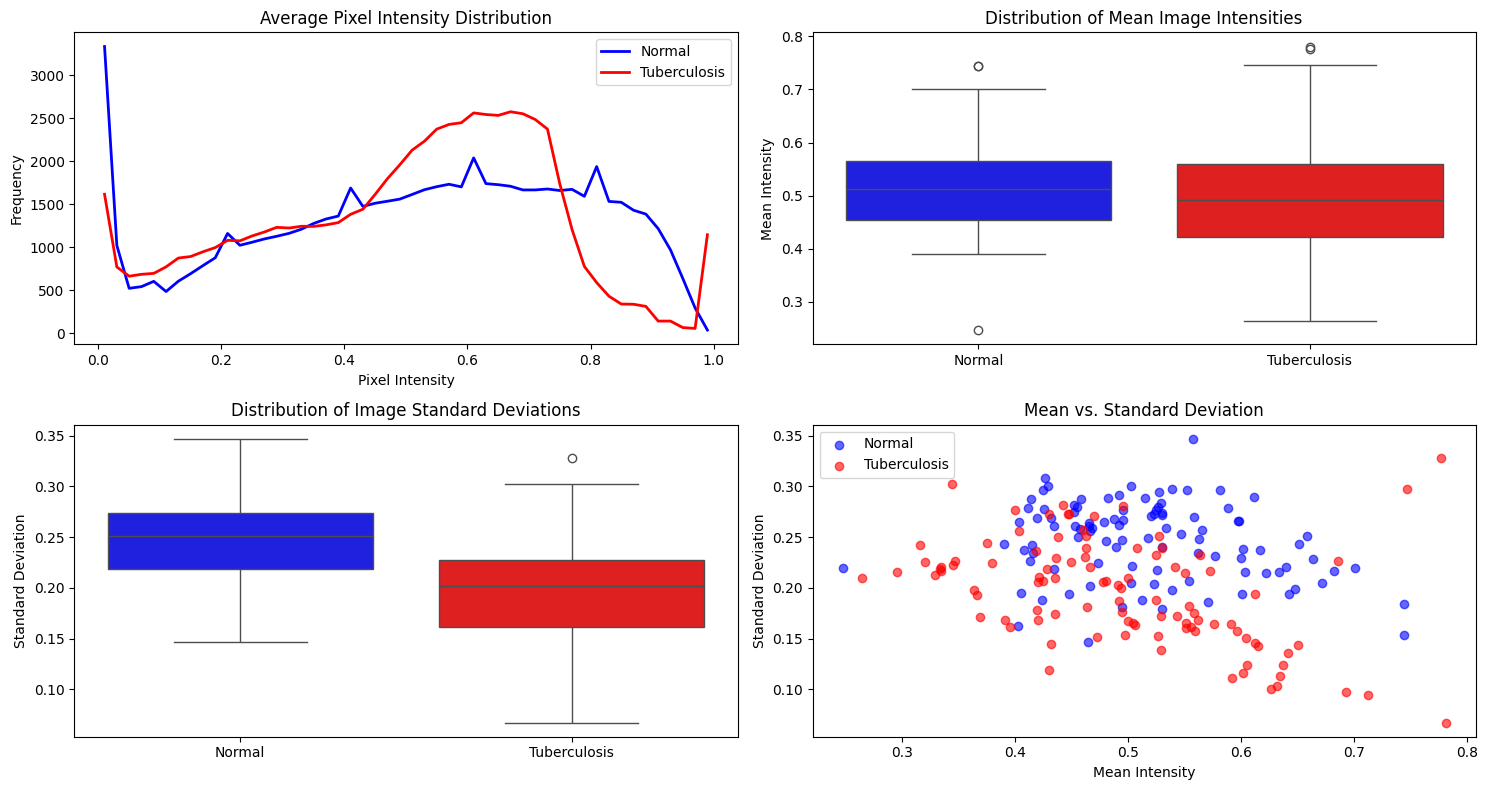

In [ ]:
# Checking out intensity patterns for normal vs TB images
plt.figure(figsize=(15, 8))

# Grab a random subset from each group (up to 100 images)
n_samples = min(100, len(normal_indices), len(tb_indices))
normal_analysis = np.random.choice(normal_indices, n_samples, replace=False)
tb_analysis = np.random.choice(tb_indices, n_samples, replace=False)

# Summation of histograms for each class
normal_hist = np.zeros(50)
tb_hist = np.zeros(50)

for idx in normal_analysis:
    image_bits = np.squeeze(X_train_resampled[idx])
    hist, _ = np.histogram(image_bits, bins=50, range=(0, 1))
    normal_hist += hist

for idx in tb_analysis:
    image_bits = np.squeeze(X_train_resampled[idx])
    hist, _ = np.histogram(image_bits, bins=50, range=(0, 1))
    tb_hist += hist

# Average histograms
normal_hist = normal_hist / n_samples
tb_hist = tb_hist / n_samples

# Plot average intensity distributions
plt.subplot(2, 2, 1)
bin_edges = np.linspace(0, 1, 51)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, normal_hist, label='Normal', color='blue', linewidth=2)
plt.plot(bin_centers, tb_hist, label='Tuberculosis', color='red', linewidth=2)
plt.legend()
plt.title('Average Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Means and stds for each category
normal_means = [np.mean(np.squeeze(X_train_resampled[idx])) for idx in normal_analysis]
normal_stds  = [np.std(np.squeeze(X_train_resampled[idx]))  for idx in normal_analysis]
tb_means     = [np.mean(np.squeeze(X_train_resampled[idx])) for idx in tb_analysis]
tb_stds      = [np.std(np.squeeze(X_train_resampled[idx]))  for idx in tb_analysis]

# Mean intensity boxplot
plt.subplot(2, 2, 2)
sns.boxplot(data=[normal_means, tb_means], palette=['blue', 'red'])
plt.xticks([0, 1], ['Normal', 'Tuberculosis'])
plt.title('Distribution of Mean Image Intensities')
plt.ylabel('Mean Intensity')

# Std dev boxplot
plt.subplot(2, 2, 3)
sns.boxplot(data=[normal_stds, tb_stds], palette=['blue', 'red'])
plt.xticks([0, 1], ['Normal', 'Tuberculosis'])
plt.title('Distribution of Image Standard Deviations')
plt.ylabel('Standard Deviation')

# Scatter: mean vs std
plt.subplot(2, 2, 4)
plt.scatter(normal_means, normal_stds, alpha=0.6, label='Normal', color='blue')
plt.scatter(tb_means, tb_stds, alpha=0.6, label='Tuberculosis', color='red')
plt.xlabel('Mean Intensity')
plt.ylabel('Standard Deviation')
plt.title('Mean vs. Standard Deviation')
plt.legend()

plt.tight_layout()
plt.show()


## 6. Create PyTorch Dataset and DataLoaders

In [ ]:
class TBChestXrayPile(Dataset):
    def __init__(self, images, labels, transform=None):
        self.imgs_data = images
        self.lbls_data = labels
        self.transform = transform

    def __len__(self):
        return len(self.imgs_data)

    def __getitem__(self, idx):
        # Raw grayscale image
        raw_pic = self.imgs_data[idx]  
        label_val = self.lbls_data[idx].astype('float32')

        # Flatten out that final channel if it's there
        if len(raw_pic.shape) == 3 and raw_pic.shape[2] == 1:
            raw_pic = np.squeeze(raw_pic, axis=-1)

        # Convert to PIL so transforms can do their thing
        pil_img = Image.fromarray((raw_pic * 255).astype('uint8'), mode='L')

        if self.transform:
            final_tensor = self.transform(pil_img)
        else:
            # if No transform then it Just make a default tensor
            final_tensor = torch.tensor(raw_pic, dtype=torch.float32).unsqueeze(0)

        label_tensor = torch.tensor(label_val, dtype=torch.float32)
        return final_tensor, label_tensor

# Transforms for training images (mix of flips, rotations, etc.) used tranformations used for medical imgs
train_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.1),
    T.RandomRotation(degrees=15),
    T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    T.ColorJitter(brightness=0.15, contrast=0.15),
    T.RandomAutocontrast(p=0.2),
    T.ToTensor(),
    T.RandomErasing(p=0.2, scale=(0.02, 0.1))
])

# Test images get turned into tensors, no fancy augmentations to keep the test imges true to actual xrays
test_transforms = T.Compose([
    T.ToTensor()
])

# Wrap training and test data in custom dataset
train_dataset = TBChestXrayPile(X_train_resampled, y_train_resampled, transform=train_transforms)
test_4D = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
test_dataset = TBChestXrayPile(test_4D, y_test, transform=test_transforms)

# DataLoaders handle batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))


Number of training samples: 4914
Number of testing samples: 1260


## Spatial Attention and CNN Model Definition

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.eye = nn.Conv2d(2, 1, kernel_size=kernel_size, 
                            padding=padding, bias=False)
        self.squash = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        stuff = torch.cat([avg_out, max_out], dim=1)
        
        attention_map = self.eye(stuff)
        attention_map = self.squash(attention_map)
        return attention_map

class SimpleAttentionCNN(nn.Module):
    def __init__(self):
        super(SimpleAttentionCNN, self).__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.3),
        )

        self.attention = SpatialAttention(kernel_size=7)

        self.brain = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        feats = self.backbone(x)
        attn_map = self.attention(feats)
        focused_feats = feats * attn_map
        out = self.brain(focused_feats)
        return out, attn_map

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleAttentionCNN().to(device)

print(model)

SimpleAttentionCNN(
  (backbone): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.2, inplace=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout2d(p=0.3, inplace=False)
  )
  (attention): SpatialAttention(
    (eye): Conv2d(2, 1, kernel_size=(7, 

## Loss Function and Optimizer Setup

In [ ]:
# Basic binary cross-entropy
loss_function = nn.BCELoss()

# Adam optimizer with weight decay to reduce overfitting
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

# LR scheduler that checks validation accuracy for deciding when to reduce LR
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=2, min_lr=1e-5, verbose=True
)


f:\Conda\envs\py310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Attention Focus Loss

In [ ]:
def attention_focus_loss(attention_map):
    try:
        # Encourages a more focused region in the attention map
        numerator = torch.sum(attention_map ** 2, dim=[2, 3])
        denominator = torch.sum(attention_map, dim=[2, 3])
        epsilon = 1e-7
        ratio = numerator / (denominator + epsilon)
        return -torch.mean(ratio)
    except Exception as e:
        print(f"Warning in focus loss calculation: {e}")
        return torch.tensor(0.0, device=attention_map.device)


## Training and Evaluation Functions

In [ ]:
def train_one_epoch(network, data_feed, opt, crit, device_thing, focus_weight=0.2):
    network.train()
    running_loss = 0.0
    running_cls_loss = 0.0
    running_focus_loss = 0.0
    correct_count = 0
    sample_count = 0
    
    for pics, labels in data_feed:
        pics = pics.to(device_thing)
        labels = labels.to(device_thing).view(-1, 1)

        opt.zero_grad()

        # Forward pass
        outputs, attn_maps = network(pics)
        
        # Classification portion
        cls_loss = crit(outputs, labels)
        
        # Extra penalty/bonus for attention shaping
        extra_loss = attention_focus_loss(attn_maps)
        
        total_loss = cls_loss + focus_weight * extra_loss
        total_loss.backward()

        # Clip gradients so training stays stable
        torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)
        opt.step()
        
        # Save stats
        batch_size = pics.size(0)
        running_loss += total_loss.item() * batch_size
        running_cls_loss += cls_loss.item() * batch_size
        running_focus_loss += extra_loss.item() * batch_size

        predicted = (outputs >= 0.5).float()
        correct_count += (predicted == labels).sum().item()
        sample_count += batch_size

    avg_loss = running_loss / sample_count
    avg_cls = running_cls_loss / sample_count
    avg_focus = running_focus_loss / sample_count
    accuracy = correct_count / sample_count

    return avg_loss, accuracy, {"cls_loss": avg_cls, "focus_loss": avg_focus}

def evaluate_model(network, data_feed, crit, device_thing):
    network.eval()
    total_loss = 0.0
    correct_count = 0
    sample_count = 0
    
    with torch.no_grad():
        for pics, labels in data_feed:
            pics = pics.to(device_thing)
            labels = labels.to(device_thing).view(-1, 1)
            
            outs, attn_maps = network(pics)
            loss_val = crit(outs, labels)
            
            batch_size = pics.size(0)
            total_loss += loss_val.item() * batch_size
            
            predictions = (outs >= 0.5).float()
            correct_count += (predictions == labels).sum().item()
            sample_count += batch_size

    avg_loss = total_loss / sample_count
    accuracy = correct_count / sample_count
    return avg_loss, accuracy


## Training Loop

Training on 4176 samples, validating on 738 samples
[Epoch 1/25] Train Loss: 0.2416 (Cls: 0.4342, Focus: -0.9630), Train Acc: 0.7984, Val Loss: 0.3142, Val Acc: 0.8686
Model improved at epoch 1, saved to tb_chest_xray_attention_best.pt
[Epoch 2/25] Train Loss: 0.1442 (Cls: 0.3433, Focus: -0.9957), Train Acc: 0.8523, Val Loss: 1.1326, Val Acc: 0.5176
[Epoch 3/25] Train Loss: 0.1411 (Cls: 0.3402, Focus: -0.9958), Train Acc: 0.8539, Val Loss: 0.2150, Val Acc: 0.9187
Model improved at epoch 3, saved to tb_chest_xray_attention_best.pt
[Epoch 4/25] Train Loss: 0.1370 (Cls: 0.3360, Focus: -0.9950), Train Acc: 0.8563, Val Loss: 0.5846, Val Acc: 0.7344
[Epoch 5/25] Train Loss: 0.1360 (Cls: 0.3348, Focus: -0.9941), Train Acc: 0.8637, Val Loss: 0.9293, Val Acc: 0.5949
[Epoch 6/25] Train Loss: 0.1589 (Cls: 0.3577, Focus: -0.9940), Train Acc: 0.8477, Val Loss: 0.2071, Val Acc: 0.9309
Model improved at epoch 6, saved to tb_chest_xray_attention_best.pt
[Epoch 7/25] Train Loss: 0.1480 (Cls: 0.3467, Fo

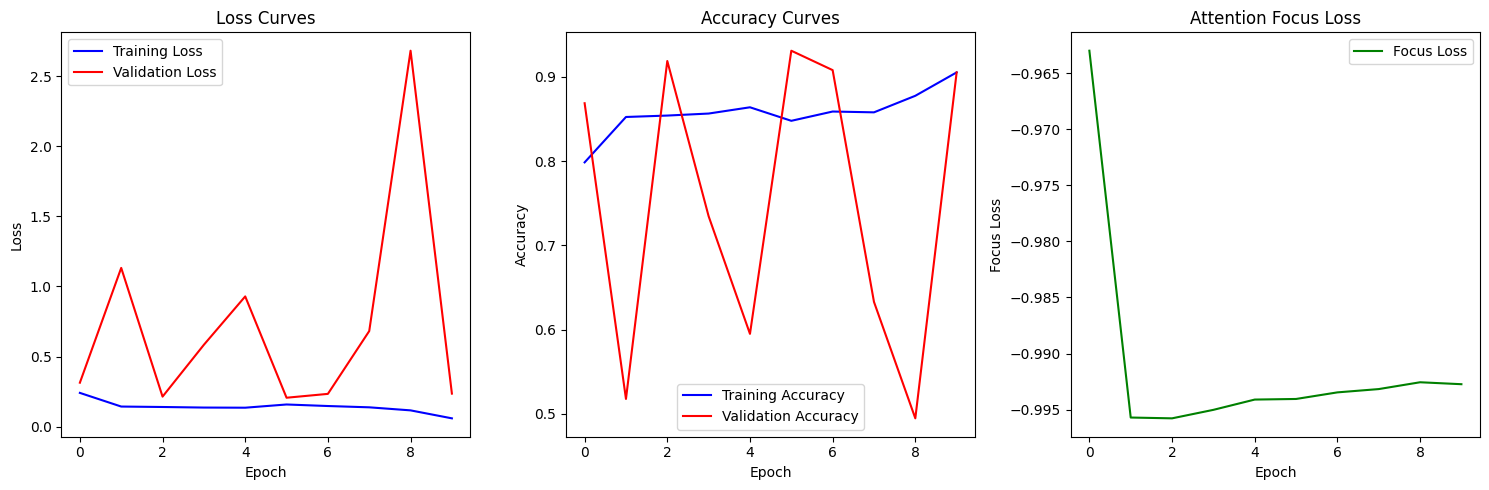

Loaded best model from tb_chest_xray_attention_best.pt


C:\Users\dell\AppData\Local\Temp\ipykernel_24280\2792019044.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [ ]:
num_epochs = 25
best_accuracy = 0.0
best_model_path = "tb_chest_xray_attention_best.pt"
patience_limit = 4
patience_counter = 0
focus_weight = 0.2

# Split some portion of training data for validation
split_count = int(0.85 * len(train_dataset))
left_count = len(train_dataset) - split_count
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [split_count, left_count])
train_loader_split = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

# Arrays to track progress
train_losses = []
val_losses = []
train_accs = []
val_accs = []
focus_losses = []

print(f"Training on {split_count} samples, validating on {left_count} samples")

for epoch in range(num_epochs):
    # Train with combined classification + attention focus
    tr_loss, tr_acc, detail_losses = train_one_epoch(
        model, train_loader_split, optimizer, loss_function, device, focus_weight=focus_weight
    )
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    focus_losses.append(detail_losses['focus_loss'])

    # Validate on hold-out subset
    v_loss, v_acc = evaluate_model(model, val_loader, loss_function, device)
    val_losses.append(v_loss)
    val_accs.append(v_acc)

    # Step the LR scheduler using validation accuracy
    lr_scheduler.step(v_acc)

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {tr_loss:.4f} (Cls: {detail_losses['cls_loss']:.4f}, Focus: {detail_losses['focus_loss']:.4f}), "
          f"Train Acc: {tr_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")
    
    # If validation improves, save model
    if v_acc > best_accuracy:
        best_accuracy = v_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Model got better at epoch {epoch+1}, saved to {best_model_path}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plotting the training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 3, 2)
plt.plot(train_accs, 'b-', label='Training Acc')
plt.plot(val_accs, 'r-', label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 3, 3)
plt.plot(focus_losses, 'g-', label='Focus Loss')
plt.xlabel('Epoch')
plt.ylabel('Focus Loss')
plt.legend()
plt.title('Attention Focus Loss')

plt.tight_layout()
plt.show()

# Load the best model
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best version from {best_model_path}")


## Model Evaluation

In [ ]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_predictions = []
all_ground_truth = []
all_raw_scores = []

with torch.no_grad():
    for pics, lbls in test_loader:
        pics = pics.to(device)
        lbls = lbls.to(device)

        out_vals, attn_map = model(pics)
        preds = (out_vals >= 0.5).float()
        
        all_predictions.extend(preds.cpu().numpy().flatten())
        all_ground_truth.extend(lbls.cpu().numpy().flatten())
        all_raw_scores.extend(out_vals.cpu().numpy().flatten())

print("CLASSIFICATION REPORT:")
print(classification_report(all_ground_truth, all_predictions, digits=4))


C:\Users\dell\AppData\Local\Temp\ipykernel_24672\4009156125.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         0.0     0.9932    0.9818    0.9875      1043
         1.0     0.9170    0.9677    0.9417       217

    accuracy                         0.9794      1260
   macro avg     0.9551    0.9748    0.9646      1260
weighted avg     0.9801    0.9794    0.9796      1260



## Confusion Matrix Visualization

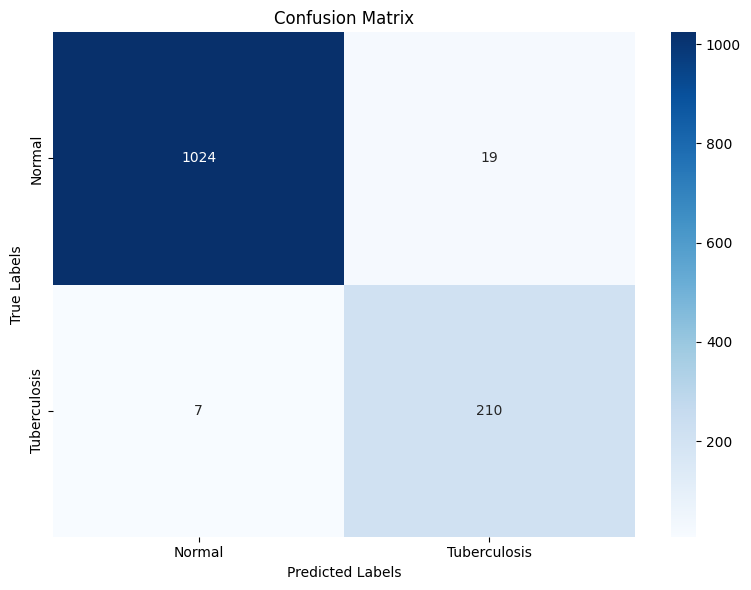

In [ ]:
plt.figure(figsize=(8, 6))

conf_mat = confusion_matrix(all_ground_truth, all_predictions)
class_names = ['Normal', 'Tuberculosis']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


## ROC Curve Analysis

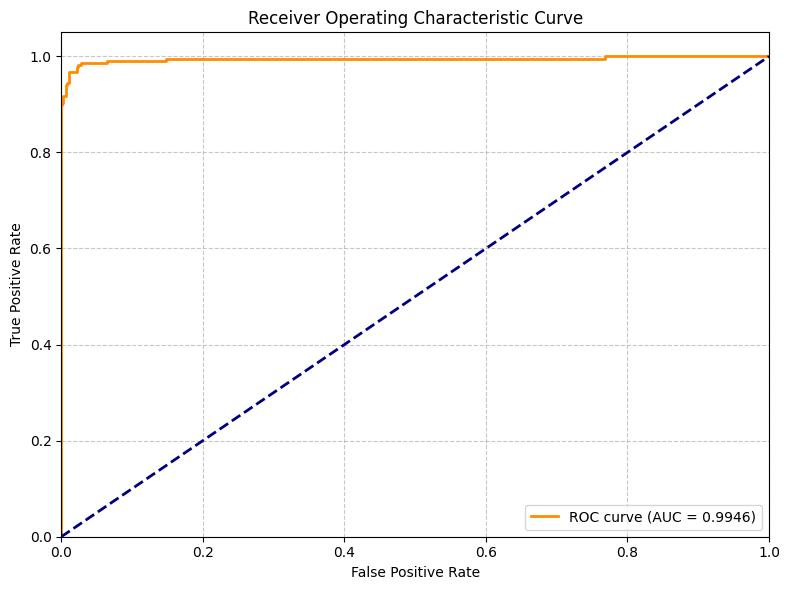

AUC-ROC Score: 0.9946


In [ ]:
# Cell 15
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

# Plotting ROC
fpr, tpr, _ = roc_curve(all_ground_truth, all_raw_scores)
roc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"AUC-ROC Score: {roc_val:.4f}")


## Precision-Recall Curve

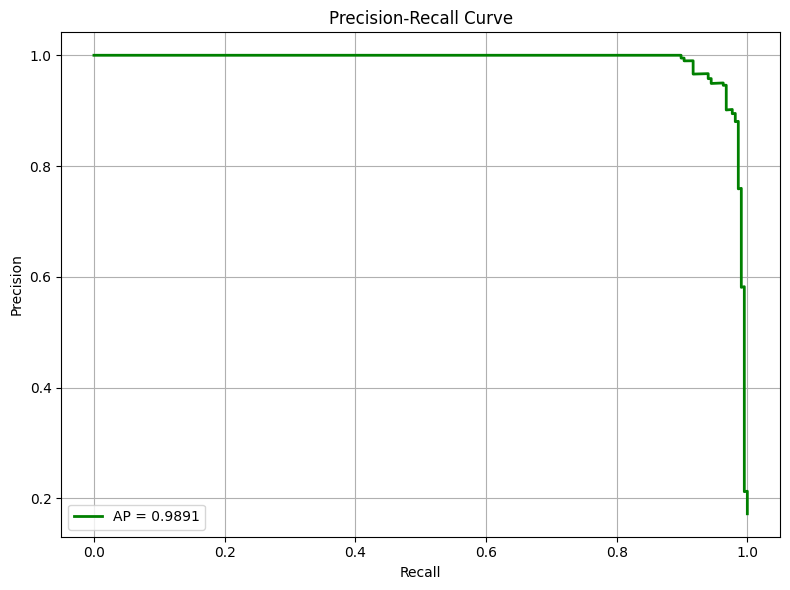

Average Precision Score: 0.9891


In [ ]:
# Cell 16
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))

# Plotting Precision-Recall
prec, rec, _ = precision_recall_curve(all_ground_truth, all_raw_scores)
avg_prec = average_precision_score(all_ground_truth, all_raw_scores)
plt.plot(rec, prec, lw=2, color='green', label=f'AP = {avg_prec:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Average Precision Score: {avg_prec:.4f}")


## Classification Metrics by Class

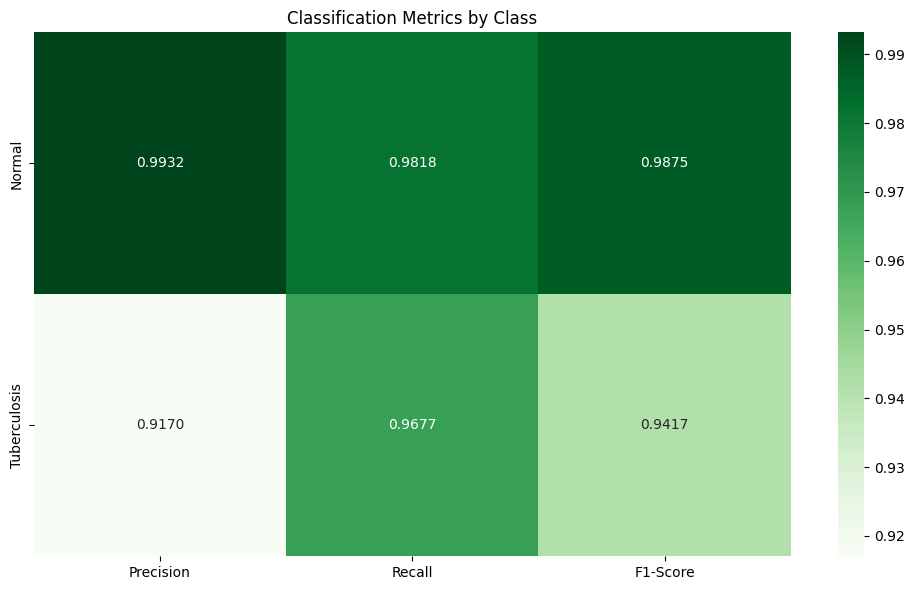

Overall Metrics:
Accuracy: 0.9794
Macro F1-Score: 0.9646
Weighted F1-Score: 0.9796


In [ ]:
# Cell 17
# Classification report as a heatmap
plt.figure(figsize=(10, 6))

report_dict = classification_report(
    all_ground_truth, all_predictions, target_names=class_names, 
    output_dict=True, digits=4
)

metrics_data = []
for c_name in class_names:
    c_info = report_dict[c_name]
    metrics_data.append([c_info['precision'], c_info['recall'], c_info['f1-score']])

df_report = pd.DataFrame(metrics_data, index=class_names,
                         columns=['Precision', 'Recall', 'F1-Score'])

sns.heatmap(df_report, annot=True, fmt='.4f', cmap='Greens')
plt.title('Classification Metrics by Class')
plt.tight_layout()
plt.show()

# Overall stats
print("Overall Metrics:")
print(f"Accuracy: {report_dict['accuracy']:.4f}")
print(f"Macro F1-Score: {report_dict['macro avg']['f1-score']:.4f}")
print(f"Weighted F1-Score: {report_dict['weighted avg']['f1-score']:.4f}")


## Utility Function for Attention Map Visualization

In [21]:
# Utility function to get sample predictions with attention maps
def get_sample_prediction_with_attention(model, dataloader, num_samples=3, device=device):
    model.eval()
    samples = []
    class_samples = {0: [], 1: []}
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs, attention_maps = model(images)
            preds = (outputs >= 0.5).float()
            
            # Get indices where prediction matches ground truth
            correct_indices = (preds.flatten() == labels).nonzero(as_tuple=True)[0]
            
            for idx in correct_indices:
                class_label = int(labels[idx].item())
                if len(class_samples[class_label]) < num_samples:
                    class_samples[class_label].append({
                        'image': images[idx].cpu(),
                        'attention': attention_maps[idx].cpu(),
                        'pred': outputs[idx].item(),
                        'label': class_label
                    })
            
            if all(len(samples) >= num_samples for samples in class_samples.values()):
                break
                
    return class_samples

# Utility Function for Attention Map Visualization

In [29]:
# Utility function to get sample predictions with attention maps
def get_sample_prediction_with_attention(model, dataloader, num_samples=3, device=device):
    model.eval()
    samples = []
    class_samples = {0: [], 1: []}
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs, attention_maps = model(images)
            preds = (outputs >= 0.5).float()
            
            # Get indices where prediction matches ground truth
            correct_indices = (preds.flatten() == labels).nonzero(as_tuple=True)[0]
            
            for idx in correct_indices:
                class_label = int(labels[idx].item())
                if len(class_samples[class_label]) < num_samples:
                    class_samples[class_label].append({
                        'image': images[idx].cpu(),
                        'attention': attention_maps[idx].cpu(),
                        'pred': outputs[idx].item(),
                        'label': class_label
                    })
            
            if all(len(samples) >= num_samples for samples in class_samples.values()):
                break
                
    return class_samples

## Class Precision Visualization

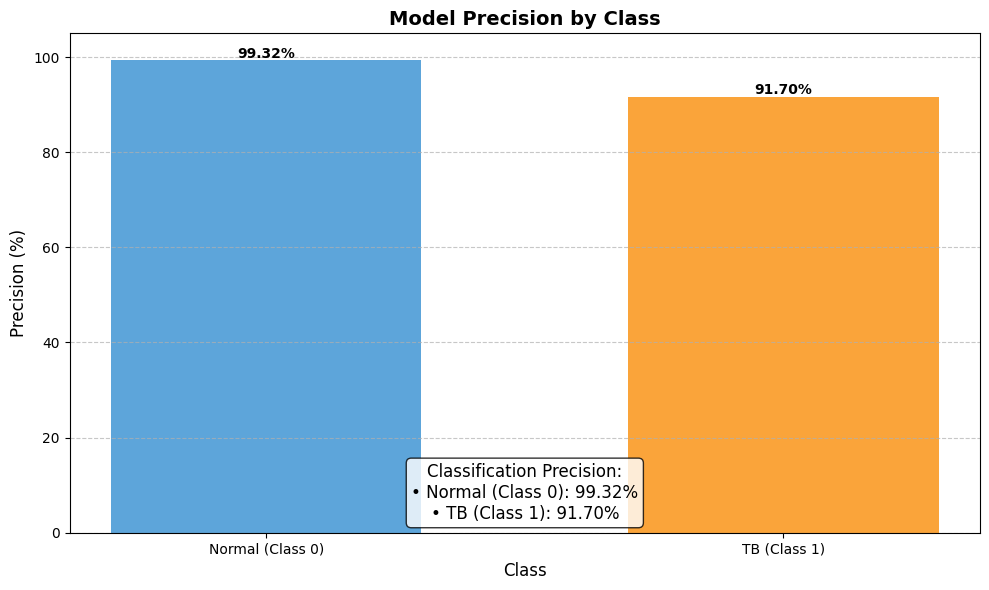

Model Precision Metrics:
- Normal (Class 0): 99.32% precision
- TB (Class 1): 91.70% precision


In [ ]:
# Visualization of class precision metrics calculated from model predictions
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score

# Calculate precision for each class from model predictions
overall_precision = precision_score(all_ground_truths, all_predictions, average=None)
normal_precision = overall_precision[0] * 100  # Class 0 (Normal)
tb_precision = overall_precision[1] * 100      # Class 1 (TB)

# For visualization - use the precision_score results
classes = ['Normal (Class 0)', 'TB (Class 1)']
precision_values = [normal_precision, tb_precision]
colors = ['#5DA5DA', '#FAA43A']  # Blue for Normal, Orange for TB

# Create the visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, precision_values, color=colors, width=0.6)

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}%', ha='center', fontweight='bold')

# Add labels and title
plt.xlabel('Class', fontsize=12)
plt.ylabel('Precision (%)', fontsize=12)
plt.title('Model Precision by Class', fontsize=14, fontweight='bold')
plt.ylim(0, 105)  # Set y-axis limit to accommodate text labels

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text box with precision information
textstr = '\n'.join([
    'Classification Precision:',
    f'• Normal (Class 0): {normal_precision:.2f}%',
    f'• TB (Class 1): {tb_precision:.2f}%'
])
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.5, 0.02, textstr, transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='bottom', horizontalalignment='center',
         bbox=props)

plt.tight_layout()
plt.show()

# Print the calculated values
print("Model Precision Metrics:")
print(f"- Normal (Class 0): {normal_precision:.2f}% precision")
print(f"- TB (Class 1): {tb_precision:.2f}% precision")